# **Processamento de dados**
#### Esse notebook serve pra carregar os arquivos Geotiff gerados no notebook Landsat.ipynb e Sentinel2.ipynb em formato de dataframe e gerar o dataframe que vai alimentar nossa rede neural, tanto o de treino quanto o de teste

In [3]:
!pip install stackstac odc-stac planetary-computer rioxarray geopandas tdqm

In [ ]:
# Multi-dimensional arrays e datasets
import xarray as xr

import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd
import matplotlib.pyplot as plt

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Processamento de imagens
from PIL import Image

# Transformação de dados
from pyproj import Proj, Transformer, CRS

# Planetary Computer 
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo



### Checking the GeoTIFF and visually interpreting the bands.

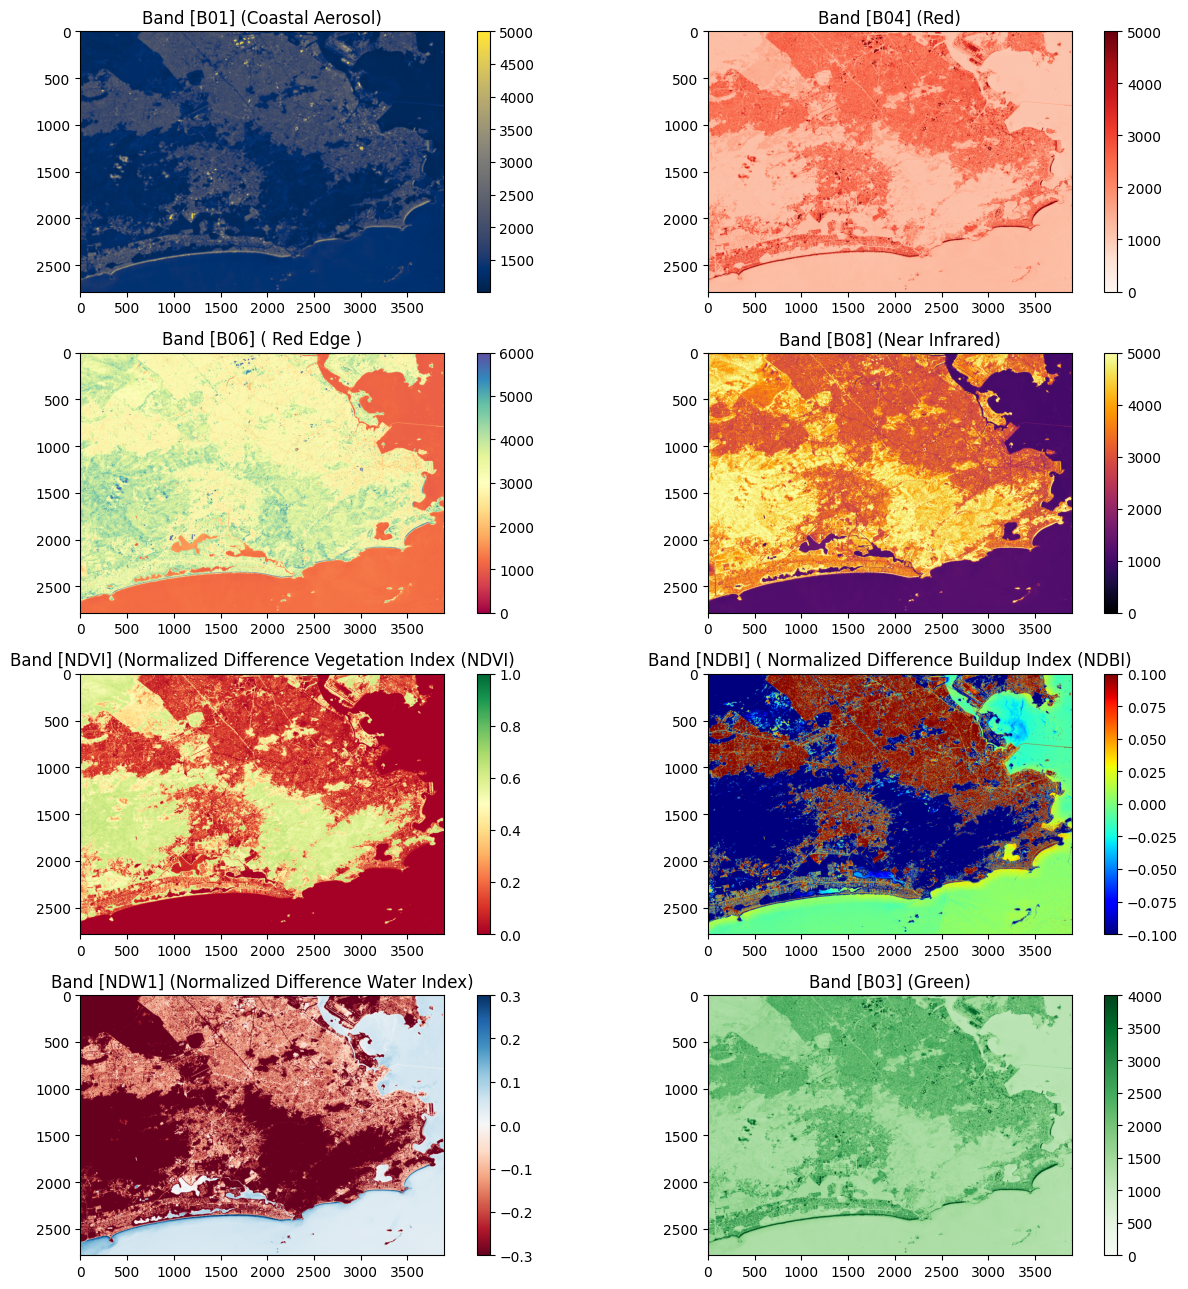

In [ ]:

# Lê e plota sete bandas (B04, B08, B06, B01 ...) do arquivo GeoTIFF.

# Abre o arquivo GeoTIFF
tiff_path = "recorte1.tiff"

# Leia as bandas do arquivo GeoTIFF usando rasterio
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]
    band5 = src1.read(5)  # Band [NDVI]
    band6 = src1.read(6)  # Band [NDBI]
    band7 = src1.read(7)  # Band [NDW1]
    band8 = src1.read(8)  # Band [B03]

# Plotando as bandas usando matplotlib
fig, axes = plt.subplots(4, 2, figsize=(13, 13))

# Ajusta o layout dos eixos
axes = axes.flatten()

# Plota a primeira banda (B01)
im1 = axes[0].imshow(band1, vmax=5000, cmap='cividis')
axes[0].set_title('Band [B01] (Coastal Aerosol)')
fig.colorbar(im1, ax=axes[0])

# Plota a segunda banda (B04)
im2 = axes[1].imshow(band2, vmax=5000,cmap='Reds')
axes[1].set_title('Band [B04] (Red)')
fig.colorbar(im2, ax=axes[1])

# Plota a terceira banda (B06)
im3 = axes[2].imshow(band3,vmax=6000 ,cmap='Spectral')
axes[2].set_title('Band [B06] ( Red Edge )')
fig.colorbar(im3, ax=axes[2])

# Plota a quarta banda (B08)
im4 = axes[3].imshow(band4, vmax=5000,cmap='inferno')
axes[3].set_title('Band [B08] (Near Infrared)')
fig.colorbar(im4, ax=axes[3])

im5=axes[4].imshow(band5, vmin=0, vmax=1,cmap='RdYlGn')
axes[4].set_title('Band [NDVI] (Normalized Difference Vegetation Index (NDVI)')
fig.colorbar(im5, ax=axes[4])

im6=axes[5].imshow(band6, vmin=-0.1, vmax=0.1,cmap='jet')
axes[5].set_title('Band [NDBI] ( Normalized Difference Buildup Index (NDBI)')
fig.colorbar(im6, ax=axes[5])

im7=axes[6].imshow(band7,vmin=-0.3, vmax=0.3, cmap='RdBu')
axes[6].set_title('Band [NDW1] (Normalized Difference Water Index)')
fig.colorbar(im7, ax=axes[6])

im8=axes[7].imshow(band8,vmax=4000,cmap='Greens')
axes[7].set_title('Band [B03] (Green)')
fig.colorbar(im8, ax=axes[7])


plt.tight_layout()
plt.show()


In [6]:
import rioxarray

def converte_df(tiff, ref_tiff=None):
    # Abre o raster
    rds = rioxarray.open_rasterio(tiff, masked=True)

    # Se for fornecido um raster de referência, reamostra para ele
    if ref_tiff is not None:
        ref = rioxarray.open_rasterio(ref_tiff, masked=True)
        rds = rds.rio.reproject_match(ref)

    # Converte para DataFrame longo: cada linha é um pixel
    df_long = rds.to_dataframe(name='value').reset_index()

    # Converte para formato largo: cada coluna é uma banda
    df_wide = df_long.pivot(index=['y', 'x'], columns='band', values='value').reset_index()

    # Renomeia colunas: latitude, longitude, bandas
    df_wide.columns = ['latitude', 'longitude'] + [f'band_{b}' for b in df_wide.columns[2:]]

    return df_wide



In [7]:
recorte1= converte_df('recorte1.tiff','Temp_recorte1.tiff')
recorte1.shape

(1205472, 10)

In [8]:
recorte2= converte_df('recorte2.tiff', 'Temp_recorte2.tiff')
recorte3= converte_df('recorte3.tiff', 'Temp_recorte3.tiff')
recorte4= converte_df('recorte4.tiff', 'Temp_recorte4.tiff')
recorte5= converte_df('recorte5.tiff', 'Temp_recorte5.tiff')
recorte6= converte_df('recorte6.tiff', 'Temp_recorte6.tiff')
recorte7= converte_df('recorte7.tiff', 'Temp_recorte7.tiff')
recorte8= converte_df('recorte8.tiff', 'Temp_recorte8.tiff')
recorte9= converte_df('recorte9.tiff', 'Temp_recorte9.tiff')

In [9]:
import pandas as pd
dfs = [recorte1, recorte2, recorte3, recorte4, recorte5,recorte7,recorte8,recorte9] 

# Concatena todos (empilha um embaixo do outro)
df_concat = pd.concat(dfs, ignore_index=True)

# Remove linhas duplicadas considerando latitude e longitude
df_unique = df_concat.drop_duplicates(subset=['latitude', 'longitude'])

# Opcional: resetar índice
df_unique = df_unique.reset_index(drop=True)

In [10]:
df_unique.shape

(5037039, 10)

In [11]:
recorte1.head()

,latitude,longitude,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8
0,-23.049865,-43.499865,1437.5,1231.5,1193.5,1199.5,-0.013163,-0.012236,0.108178,1490.5
1,-23.049865,-43.499596,1447.0,1249.0,1194.5,1199.5,-0.020216,-0.014162,0.112796,1504.5
2,-23.049865,-43.499326,1447.0,1209.5,1192.5,1196.5,-0.005403,-0.011625,0.103073,1471.5
3,-23.049865,-43.499057,1439.0,1203.5,1180.0,1203.5,0.000000,-0.015183,0.106699,1491.0
4,-23.049865,-43.498788,1439.0,1197.0,1144.5,1187.0,-0.004195,-0.020636,0.093547,1432.0


In [12]:
temp1=converte_df('Temp_recorte1.tiff')
temp2=converte_df('Temp_recorte2.tiff')
temp3=converte_df('Temp_recorte3.tiff')
temp4=converte_df('Temp_recorte4.tiff')
temp5=converte_df('Temp_recorte5.tiff')
temp6=converte_df('Temp_recorte6.tiff')
temp7=converte_df('Temp_recorte7.tiff')
temp8=converte_df('Temp_recorte8.tiff')
temp9=converte_df('Temp_recorte9.tiff')

temp_dfs = [temp1, temp2, temp3, temp4, temp5,temp7,temp8,temp9]
# Concatena todos (empilha um embaixo do outro)
temp_concat = pd.concat(temp_dfs, ignore_index=True)
# Remove linhas duplicadas considerando latitude e longitude
temp_unique = temp_concat.drop_duplicates(subset=['latitude', 'longitude'])
# Opcional: resetar índice
temp_unique = temp_unique.reset_index(drop=True)
# Merge com o DataFrame único
df = temp_unique.merge(df_unique, on=['latitude', 'longitude'], how='left')
df.shape

(5037039, 11)

In [13]:
temp1.head()

,latitude,longitude,band_1
0,-23.049865,-43.499865,24.574886
1,-23.049865,-43.499596,24.588558
2,-23.049865,-43.499326,24.591976
3,-23.049865,-43.499057,24.591976
4,-23.049865,-43.498788,24.598812


In [14]:
df.isnull().sum()

latitude     0
longitude    0
band_1_x     0
band_1_y     0
band_2       0
band_3       0
band_4       0
band_5       2
band_6       2
band_7       2
band_8       0
dtype: int64

In [15]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = df[col].astype('float32')
df.shape

(5037039, 11)

In [16]:
df=df.rename(columns={'band_1_x': 'LST', 'band_1_y': 'B01'})
df.head()

,latitude,longitude,LST,B01,band_2,band_3,band_4,band_5,band_6,band_7,band_8
0,-23.049866,-43.499866,24.574886,1437.5,1231.5,1193.5,1199.5,-0.013163,-0.012236,0.108178,1490.5
1,-23.049866,-43.499596,24.588558,1447.0,1249.0,1194.5,1199.5,-0.020216,-0.014162,0.112796,1504.5
2,-23.049866,-43.499325,24.591976,1447.0,1209.5,1192.5,1196.5,-0.005403,-0.011625,0.103073,1471.5
3,-23.049866,-43.499058,24.591976,1439.0,1203.5,1180.0,1203.5,0.000000,-0.015183,0.106699,1491.0
4,-23.049866,-43.498787,24.598812,1439.0,1197.0,1144.5,1187.0,-0.004195,-0.020636,0.093547,1432.0


In [17]:

df_test = temp6.merge(recorte6, on=['latitude', 'longitude'], how='left')
df_test= df_test.rename(columns={'band_1_x': 'LST', 'band_1_y': 'B01'})
for col in df_test.columns:
    if df_test[col].dtype == 'float64':
        df_test[col] = df_test[col].astype('float32')
df_test.shape


(518382, 11)

In [18]:
df.columns

Index(['latitude', 'longitude', 'LST', 'B01', 'band_2', 'band_3', 'band_4',
       'band_5', 'band_6', 'band_7', 'band_8'],
      dtype='object')

In [19]:
df_test.columns

Index(['latitude', 'longitude', 'LST', 'B01', 'band_2', 'band_3', 'band_4',
       'band_5', 'band_6', 'band_7', 'band_8'],
      dtype='object')

In [20]:
df.shape,df_test.shape

((5037039, 11), (518382, 11))

In [21]:
df.to_csv('df_final.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [22]:
temp4['band_1'].max()

np.float64(49.317933020000055)

In [23]:
resolution = 30  # metros por pixel
scale = resolution / 111320.0  # ≈ 0.0002695 graus por pixel